In [25]:
import json
import cv2 
import matplotlib.pyplot as plt
import re 

def draw_boxes_on_image(image_path:str, annot_path:str)->None:
    image = cv2.imread(image_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image_id : image (1) 
    match = re.search(r'image \(\d+\)', image_path)
    if match:
        image_id = match.group()
    print(image_id)
    with open(annot_path, 'r') as f:
        annotations: list[dict] = json.load(f)["annotations"]

    for ann in annotations:
        if ann['image_id'] == image_id:
            xmin, ymin = ann['bbox'][0], ann['bbox'][1]
            xmax, ymax = (xmin + ann['bbox'][2]), (ymin + ann['bbox'][3])
            class_id = ann['category_id']
            class_name = 'person' if 1 else ''
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image, class_name, (xmin, ymin- 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.show()

image (3)


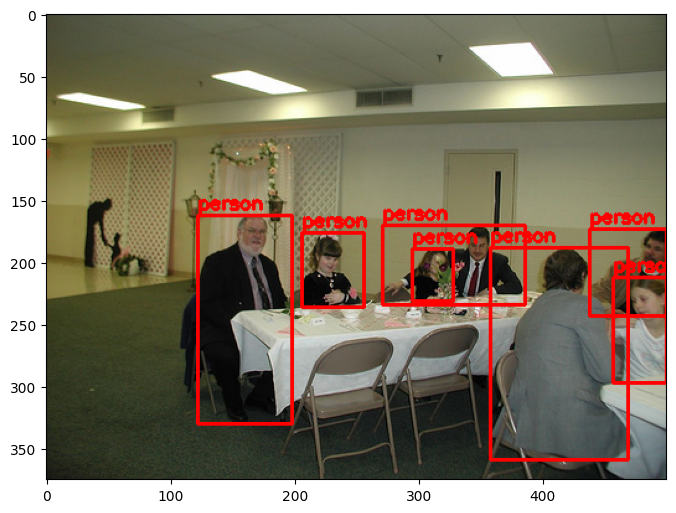

In [26]:
image_path = '/home/yoojinoh/Others/PR/PedDetect/data/Train/Train/JPEGImages/image (3).jpg'
annot_path = '/home/yoojinoh/Others/PR/PedDetect/data/Train/Train/train_annotations.json'

draw_boxes_on_image(image_path=image_path, annot_path=annot_path)

In [70]:
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd 
import os
import torch 
from PIL import Image 
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from xml.etree import ElementTree

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
from tqdm.auto import tqdm

device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# print(device)

CFG = {
    'NUM_CLASS':2,
    'IMG_SIZE':512,
    'EPOCHS':10, # 20
    'LR':3e-4,
    'BATCH_SIZE':4,
    'SEED':41,
}

class PedestrianDataset(Dataset):
    def __init__(self,
                 root: str, # '/home/yoojinoh/Others/PR/PedDetect/data
                 split: str = "train", # /home/yoojinoh/Others/PR/PedDetect/data/Train/Train
                 transforms= None):
        super().__init__()
        split = split.capitalize() # train -> Train 
        self.root = root        
        
        annotation_path = os.path.join(root, split, split, f'{split.lower()}_annotations.json')
        with open(annotation_path) as f:
            raw_annotations: list[dict] = json.load(f)["annotations"]
        fname_to_annotation: dict[str, dict] = defaultdict(list)
        for ann in raw_annotations:
            fname_to_annotation[(ann['image_id'])+ ".jpg"].append(ann)
        
        image_paths = os.listdir(os.path.join(root, split, split, 'JPEGImages'))
        image_paths = sorted([os.path.join(root, split, split, 'JPEGImages', path) for path in image_paths])

        image_paths = sorted([path for path in image_paths if os.path.basename(path) in fname_to_annotation])
        annotations = [fname_to_annotation[os.path.basename(path)] for path in image_paths]
        assert len(image_paths) == len(annotations), "Number of images and labels does not match"

        self.local_images = image_paths
        self.local_annotations = annotations

        self.transforms = transforms
    def __len__(self):
        return len(self.local_images)
    
    def __getitem__(self, idx):
        path = self.local_images[idx]
        anns: list[dict] = self.local_annotations[idx] 
        labels: list = []
        boxes: list = []

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 

        for ann in anns:
            print(ann['image_id'])
            x1, y1, w, h = ann['bbox'] 
            x1 = int(x1)
            y1 = int(y1) 
            x2 = x1 + int(w) 
            y2 = y1 + int(h) 

            label = ann['category_id']
            labels.append(label)
            boxes.append([x1, y1, x2, y2])
        
        # convert boxes and labels into tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype = torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = int(re.findall(r'\d+', ann['image_id'])[0])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([image_id])

        if self.transforms:
                transformed = self.transforms(image = image,
                                     bboxes = boxes,
                                     labels = labels)
                image = transformed['image']
                target['boxes'] = torch.Tensor(transformed['bboxes'])
             
        return image, target 

        
# same as 'https://www.kaggle.com/code/a0121543/pedestrian-detection-with-pytorch'        
def train_transforms():
     return transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=(-5, 5), translate=(0, 0.1), scale=(1.0, 1.25), shear=(-10, 10)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def test_transforms():
     return transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
])





In [71]:
dataset = PedestrianDataset('/home/yoojinoh/Others/PR/PedDetect/data')
print('length of dataset = ', len(dataset), '\n')

length of dataset =  944 



In [72]:
torch.tensor([17])

tensor([17])

In [73]:
img, target = dataset[78]
print(img.shape, '\n',target)

image (17)
(375, 500, 3) 
 {'boxes': tensor([[ 62.,  23., 382., 296.]]), 'labels': tensor([1]), 'area': tensor([87360.]), 'iscrowd': tensor([0]), 'image_id': tensor([17])}


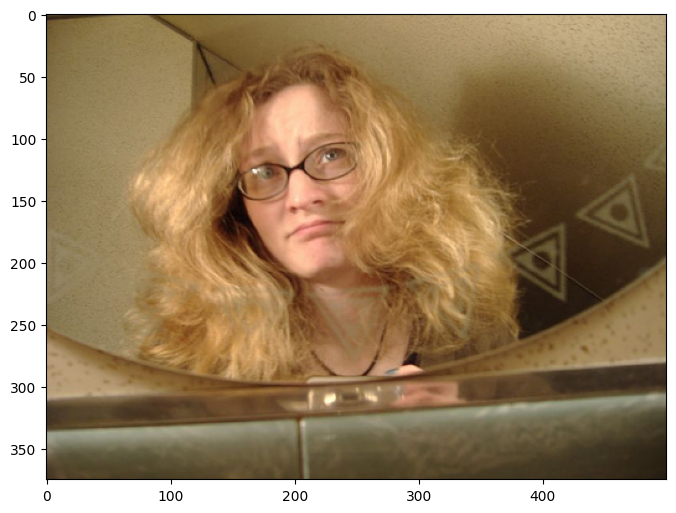

In [74]:
image = img 
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

In [3]:
import json  

annot_path = '/home/yoojinoh/Others/PR/PedDetect-Data/data/Train/Train/train_annotations.json'

with open(annot_path, 'r') as f:
    annots = json.load(f)

print(annots['annotations'])

[{'image_id': 'image (718)', 'category_id': 0, 'bbox': [38, 21, 195, 162]}, {'image_id': 'image (939)', 'category_id': 0, 'bbox': [181, 324, 166, 620]}, {'image_id': 'image (939)', 'category_id': 0, 'bbox': [437, 193, 128, 565]}, {'image_id': 'image (939)', 'category_id': 0, 'bbox': [482, 332, 165, 615]}, {'image_id': 'image (939)', 'category_id': 0, 'bbox': [721, 324, 116, 615]}, {'image_id': 'image (939)', 'category_id': 0, 'bbox': [922, 155, 137, 398]}, {'image_id': 'image (939)', 'category_id': 0, 'bbox': [1034, 296, 152, 643]}, {'image_id': 'image (164)', 'category_id': 1, 'bbox': [358, 50, 142, 283]}, {'image_id': 'image (164)', 'category_id': 1, 'bbox': [9, 41, 248, 292]}, {'image_id': 'image (548)', 'category_id': 0, 'bbox': [17, 272, 91, 198]}, {'image_id': 'image (548)', 'category_id': 0, 'bbox': [108, 355, 64, 113]}, {'image_id': 'image (548)', 'category_id': 0, 'bbox': [142, 133, 129, 333]}, {'image_id': 'image (548)', 'category_id': 0, 'bbox': [217, 263, 89, 173]}, {'image

In [7]:
(annots['annotations'])[0].keys()

dict_keys(['image_id', 'category_id', 'bbox'])